✅ Data loaded successfully
🧠 Available columns (stock names):
Index(['Date', 'RELIANCE', 'TCS', 'HDFCBANK', 'ICICIBANK', 'BHARTIARTL',
       'SBIN', 'INFY', 'LICI', 'ITC',
       ...
       'COOLCAPS', 'ALLETEC', '20MICRONS', 'VIKASECO', 'ORIENTBELL', 'DONEAR',
       'CAREERP', 'INTLCONV', 'SHREEPUSHK', 'PRITIKAUTO'],
      dtype='object', length=1418)
Enter the stock name (column header, e.g., IOC): TCS

📉 Performing LSTM prediction for TCS...
Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0045
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 6.7531e-05
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 6.5767e-05
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 6.9927e-05
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 6.8900e-05
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 7.2827e-05
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 6.3076e-05
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 46

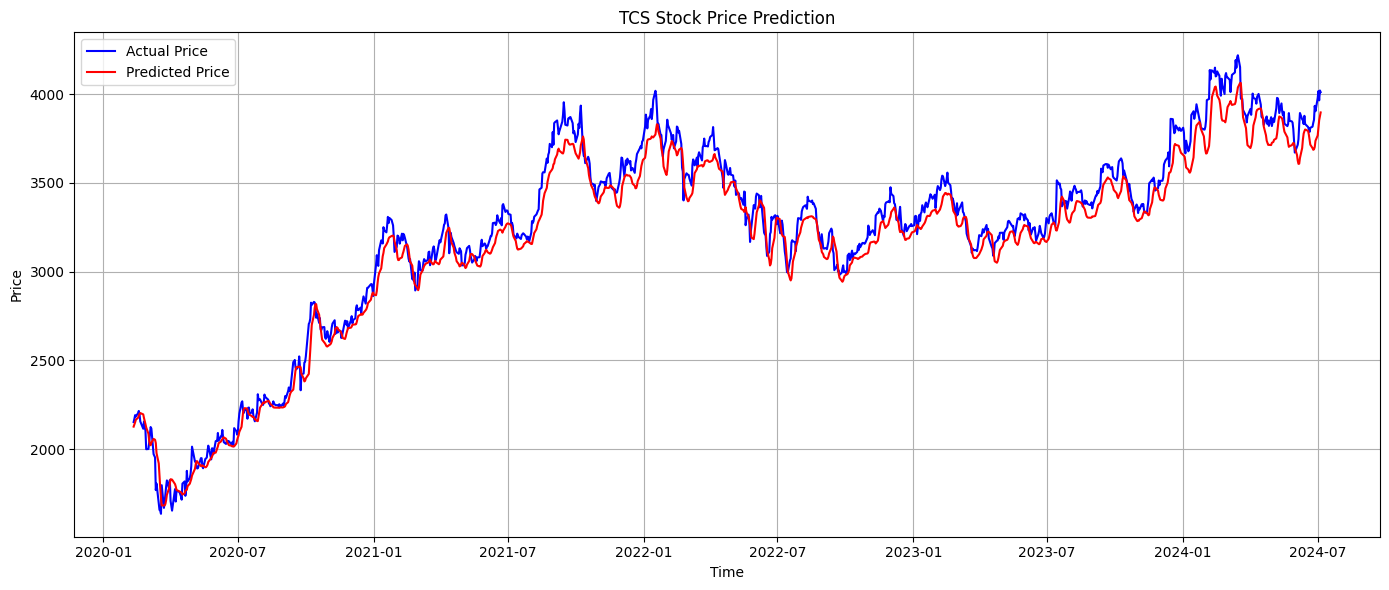

In [14]:
# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import math

# STEP 2: Load Dataset
df = pd.read_csv('/content/nse_all_stock_data (1).csv')
print("✅ Data loaded successfully")
print("🧠 Available columns (stock names):")
print(df.columns)

# STEP 3: Check if Date column exists
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df.set_index('Date', inplace=True)

# STEP 4: Ask user for stock name
stock_name = input("Enter the stock name (column header, e.g., IOC): ").strip().upper()

# STEP 5: Validate stock name
if stock_name not in df.columns:
    print(f"❌ Stock '{stock_name}' not found in dataset.")
else:
    print(f"\n📉 Performing LSTM prediction for {stock_name}...")

    stock_prices = df[[stock_name]].dropna()

    # Normalize
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(stock_prices)

    # Train-test split
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - 60:]

    # Sequence creation
    def create_dataset(data, time_step=60):
        x, y = [], []
        for i in range(time_step, len(data)):
            x.append(data[i-time_step:i, 0])
            y.append(data[i, 0])
        return np.array(x), np.array(y)

    x_train, y_train = create_dataset(train_data)
    x_test, y_test = create_dataset(test_data)

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    # Build LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=20, batch_size=32)

    # Prediction
    predictions = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predictions)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Prepare result DataFrame
    result_df = pd.DataFrame({
        'Actual Price': actual_prices.flatten(),
        'Predicted Price': predicted_prices.flatten()
    })

    if 'Date' in df.index.names:
        result_df['Date'] = stock_prices.index[-len(actual_prices):]
        result_df.set_index('Date', inplace=True)

    # Save to CSV
    filename = f"{stock_name}_Predicted_vs_Actual.csv"
    result_df.to_csv(filename)
    print(f"\n✅ Prediction complete. Results saved to: {filename}")

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(result_df['Actual Price'], label='Actual Price', color='blue')
    plt.plot(result_df['Predicted Price'], label='Predicted Price', color='red')
    plt.title(f"{stock_name} Stock Price Prediction")
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
